In [156]:
import pandas as pd, sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime, calendar, time
import matplotlib.dates as mdates
import matplotlib.colors as colors
import matplotlib.ticker
%matplotlib inline

### Set the city for analysis
Loads the city file from `../data`

In [157]:
PLACE = "detroit_michigan"

Read in the versions file

In [158]:
header = ['id','type','amenity','highway','building','name','length','area','aA','aD','aM','user', 'version','minorVersion','validSince','validUntil','changeset','center']

In [159]:
df = pd.read_csv('../data/'+PLACE+'-all-stats.data',names=header, sep='\t',index_col=None)
df.sort_values(by='validSince',inplace=True)
df = df.reset_index(drop=True)
df.head(2)

,id,type,amenity,highway,building,name,length,area,aA,aD,aM,user,version,minorVersion,validSince,validUntil,changeset,center
0,11753030,node,NaN,traffic_signals,NaN,NaN,NaN,NaN,NaN,NaN,NaN,purpleduck,1,NaN,1154027235,1204584703,68453,"-83.0171595,42.2546319"
1,18353607,node,NaN,NaN,NaN,NaN,NaN,NaN,railway-->crossing|-|created_by-->JOSM,NaN,NaN,rw_,1,NaN,1161039615,1206935185,133880,"-82.5525158,42.2359087"


Calculate new columns and convert to Python objects

In [160]:
df['date'] = df.validSince.apply(lambda x: pd.Timestamp(x*1000000000).date())
df.replace("false", np.NaN, inplace=True)
df.validUntil = df['validUntil'].astype(float)

#Cast length and area to floats
df.length = pd.to_numeric(df.length, downcast='float')
df.area = pd.to_numeric(df.length, downcast='float')
df.version = pd.to_numeric(df.version, downcast='integer')

In [161]:
print("Loaded {:,} edits to {:,} objects from {:,} users".format( df.id.count(), df.id.nunique(), df.user.nunique()) );

Loaded 317,662 edits to 151,522 objects from 1,042 users


# 1. Kilometers of roads over time

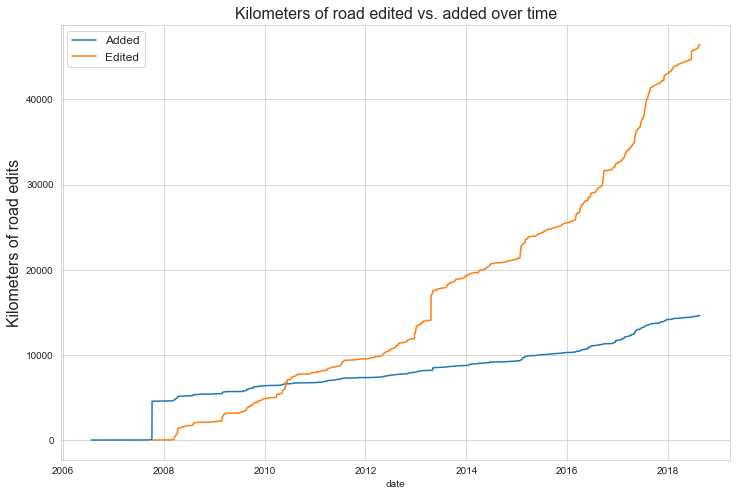

In [162]:
sns.set_style('whitegrid')
hw = df[~pd.isnull(df.highway)]
ax = hw[hw.version==1].groupby('date').aggregate({'length':sum}).cumsum().plot(figsize=(12,8),legend=None)
hw[hw.version>1].groupby('date').aggregate({'length':sum}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Kilometers of road edits",fontsize=16)
ax.set_title("Kilometers of road edited vs. added over time",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

# 2 Buildings Over time

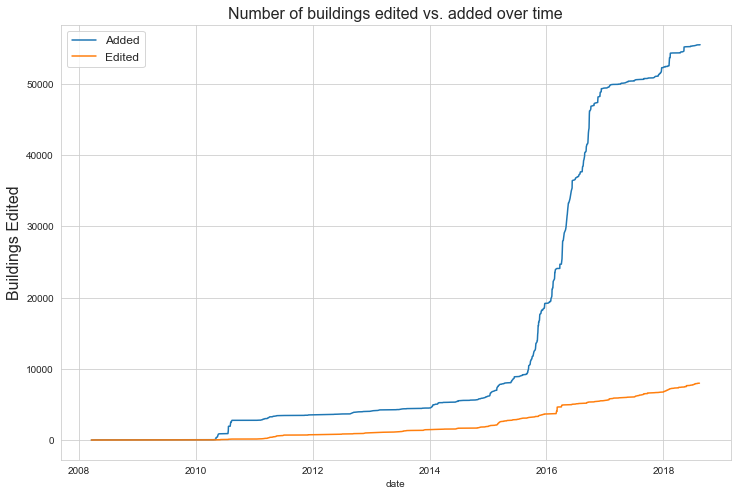

In [163]:
sns.set_style('whitegrid')
buildings = df[~pd.isnull(df.building)]
ax = buildings[(buildings.version==1) & (buildings.minorVersion==0)].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(figsize=(12,8),legend=None)
buildings[buildings.version>1].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Buildings Edited",fontsize=16)
ax.set_title("Number of buildings edited vs. added over time",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

### Top Building Contributors (Added)

In [164]:
buildings[(buildings.minorVersion==0) & (buildings.version==1)].groupby('user').aggregate({
    'id':'count'}).sort_values(by='id',ascending=False).head(10)

,id
user,
markscalf,20448
Aibara,15907
PeterEastern,2720
Tyson Gersh,1863
leppekmi,1785
MintCondition,1752
dexterslu,1327
DougPeterson,1036
Stevedawg313,864


### Top Building Contributors (Recently)

In [165]:
buildings[(buildings.minorVersion==0) & (buildings.version==1) & 
          (buildings.date > datetime.date(2018,8,1))].groupby('user').aggregate(
            {'id':'count'}).sort_values(by='id',ascending=False).head(10)

,id
user,
Osgood,23
Jonah Adkins,13
lmum,3
Flight Detroit,2
StackKorora,1
StudentinGear,1


# 3 Amenities Over time

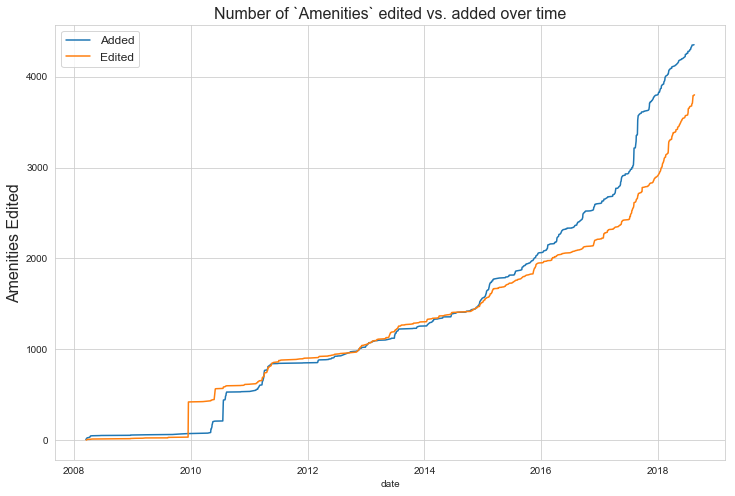

In [166]:
sns.set_style('whitegrid')
amenities = df[~pd.isnull(df.amenity)]
ax = amenities[(amenities.version==1) & (amenities.minorVersion==0)].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(figsize=(12,8),legend=None)
amenities[amenities.version>1].groupby('date').aggregate({'id':'nunique'}).cumsum().plot(ax=ax,legend=None)
ax.set_ylabel("Amenities Edited",fontsize=16)
ax.set_title("Number of `Amenities` edited vs. added over time",fontsize=16);
ax.legend(['Added','Edited'], loc=0, fontsize=12);

# 4 Contributors per week ... an editing pulse?

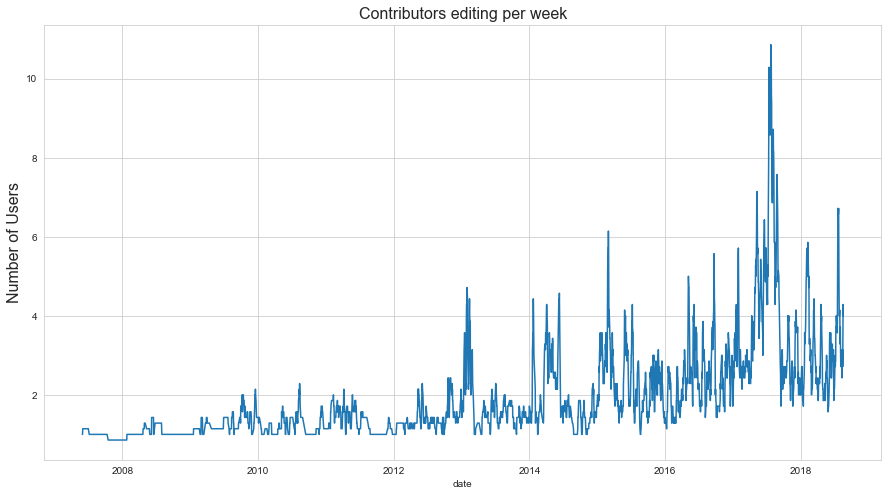

In [167]:
ax = df.groupby('date').aggregate({'user':'nunique'}).rolling(7).mean().plot(figsize=(15,8),legend=None)
ax.set_ylabel("Number of Users",fontsize=16)
ax.set_title("Contributors editing per week",fontsize=16);

# 5 Edits per week?

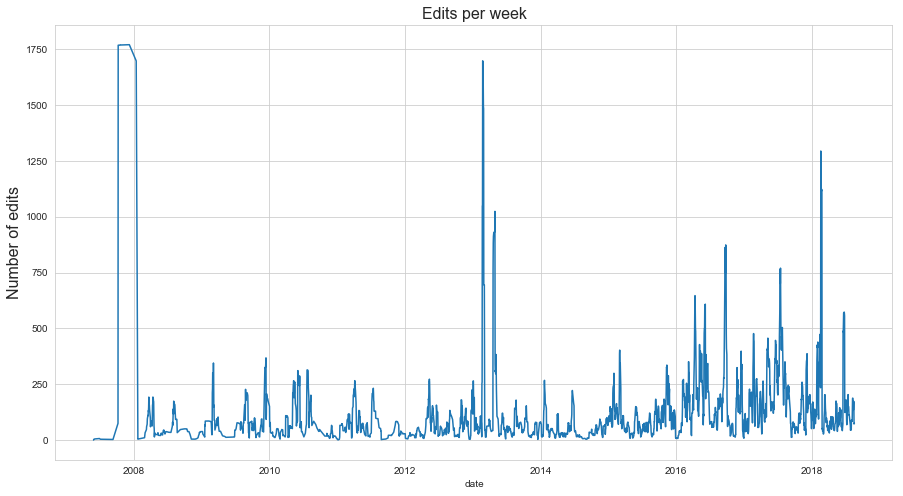

In [168]:
ax = df.groupby('date').aggregate({'id':'count'}).rolling(7).mean().plot(figsize=(15,8),legend=None)
ax.set_ylabel("Number of edits",fontsize=16)
ax.set_title("Edits per week",fontsize=16);

# 6 Users over time

In [169]:
# Kudos to Seth on this algorithm :) 
unique_users_over_time = df.groupby('user').aggregate(
    {'date':min}).reset_index().groupby('date').aggregate({'user':'count'})

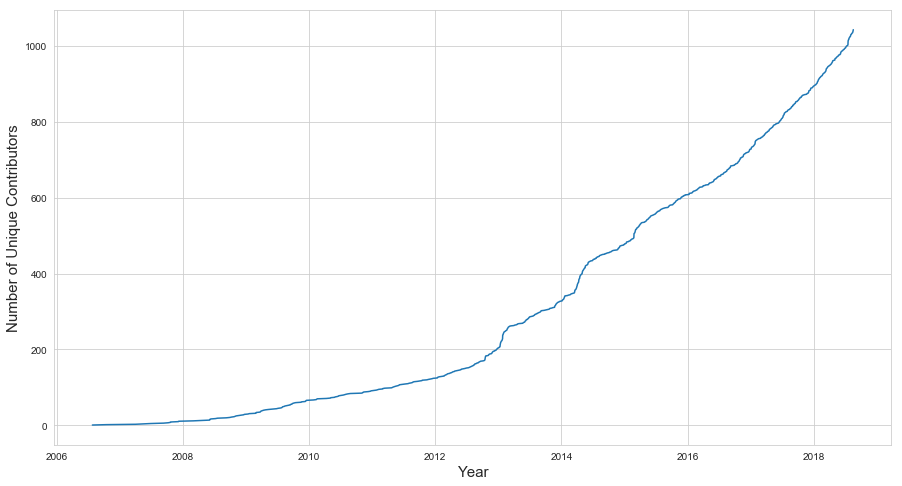

In [170]:
sns.set_style('whitegrid')
ax = unique_users_over_time.cumsum().plot(figsize=(15,8),legend=None)
ax.set_ylabel('Number of Unique Contributors', fontsize=15)
ax.set_xlabel('Year', fontsize=15);

# 7 Contributor Co-Editing Network

In [171]:
import networkx as nx

In [172]:
G = nx.DiGraph()
for line in open('../data/'+PLACE+'-users.edgelist','r'):
    sourceLabel, targetLabel, weight = line.split(",")
    weight = int(weight)
    if weight > 100:
        G.add_edge(sourceLabel, targetLabel, weight=weight)

In [173]:
len(G.nodes())

80

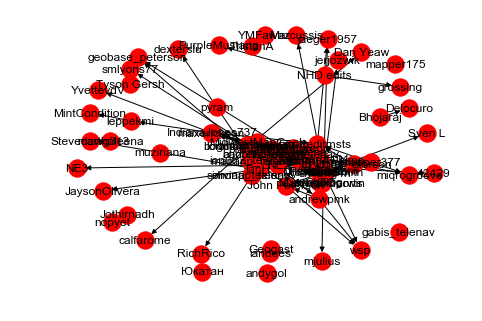

In [174]:
nx.draw_spring(G, with_labels=True)

In [175]:
nx.write_graphml(G,'../data/'+PLACE+'.graphml');
print("View the GML file in the data diretory: ../data/"+PLACE+".graphml")
print("Recommend downloading GEPHI: https://gephi.org/ to view this file")

View the GML file in the data diretory: ../data/detroit_michigan.graphml
Recommend downloading GEPHI: https://gephi.org/ to view this file


# 8 Versions

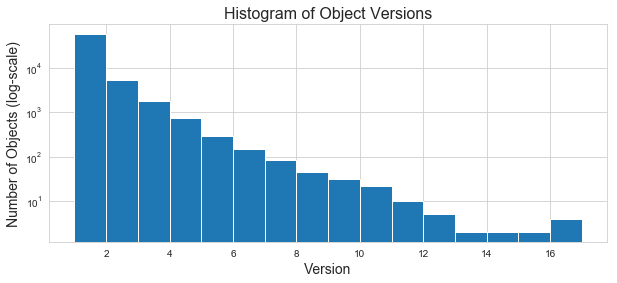

In [176]:
ax = buildings.version.hist(figsize=(10,4),bins=np.arange(1,buildings.version.max(),1))
ax.set_yscale('log'); ax.set_title('Histogram of Object Versions', fontsize=16)
ax.set_xlabel("Version",fontsize=14); ax.set_ylabel("Number of Objects (log-scale)",fontsize=14);

### Most edited buildings?

In [177]:
buildings.sort_values(by='version', ascending=False).head()

,id,type,amenity,highway,building,name,length,area,aA,aD,aM,user,version,minorVersion,validSince,validUntil,changeset,center,date
303395,30259592,way,NaN,NaN,yes,Cobo Center,NaN,NaN,addr:city-->Detroit|-|addr:housenumber-->1|-|a...,name-->Cobo Hall<-->Cobo Center,NaN,StudentinGear,18,0.0,1524490074,NaN,58339242,"-83.04887973823527,42.327181152941165",2018-04-23
317131,30259672,way,NaN,NaN,yes,Ford Michigan Central Train Depot,NaN,NaN,name-->Ford Michigan Central Train Depot,NaN,NaN,littlejk1,17,0.0,1533960202,NaN,61557085,"-83.0777309043478,42.32872867826087",2018-08-11
301752,30259592,way,NaN,NaN,yes,Cobo Center,NaN,NaN,alt_name-->Cobo Center,NaN,NaN,mvexel,17,0.0,1522167454,1.524490e+09,57572536,"-83.04887973823527,42.327181152941165",2018-03-27
299016,30259592,way,NaN,NaN,yes,Cobo Center,NaN,NaN,NaN,NaN,NaN,Delocuro,16,0.0,1519543995,1.522167e+09,56653484,"-83.04887973823527,42.327181152941165",2018-02-25
316198,30259672,way,NaN,NaN,yes,Ford Michigan Central Train Depot,NaN,NaN,NaN,NaN,NaN,StudentinGear,16,0.0,1533405979,1.533960e+09,61359171,"-83.0777309043478,42.32872867826087",2018-08-04


# Minor Versions?

In [178]:
df.minorVersion.value_counts().head()

0.0    240848
1.0     21480
2.0      3486
3.0       777
4.0       225
Name: minorVersion, dtype: int64

In [179]:
print("Number of uncounted minor geometry edits: {:,}".format( int(df.query('minorVersion>0').minorVersion.sum())) )

Number of uncounted minor geometry edits: 32,347


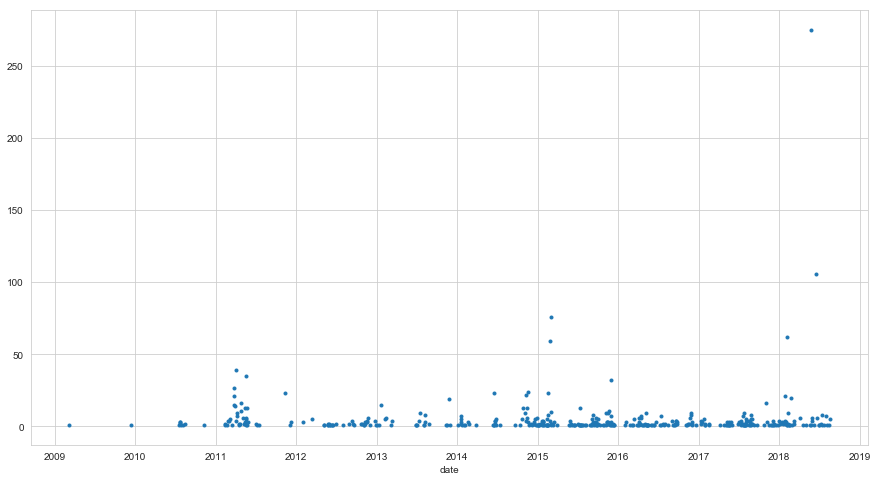

In [180]:
df2 = buildings[buildings.minorVersion>0].groupby('date').aggregate({'id':'count'})
df2.plot(figsize=(15,8), legend=None, marker='.', linewidth=0);
ax.set_title("When Minor Versions Happen (Geometry Only Changes)",fontsize=16); ax.set_ylabel("Number of edits")
ax.set_xlabel("Date", fontsize=14);

# 10 Evolution of the Map: Roads --> Buildings?

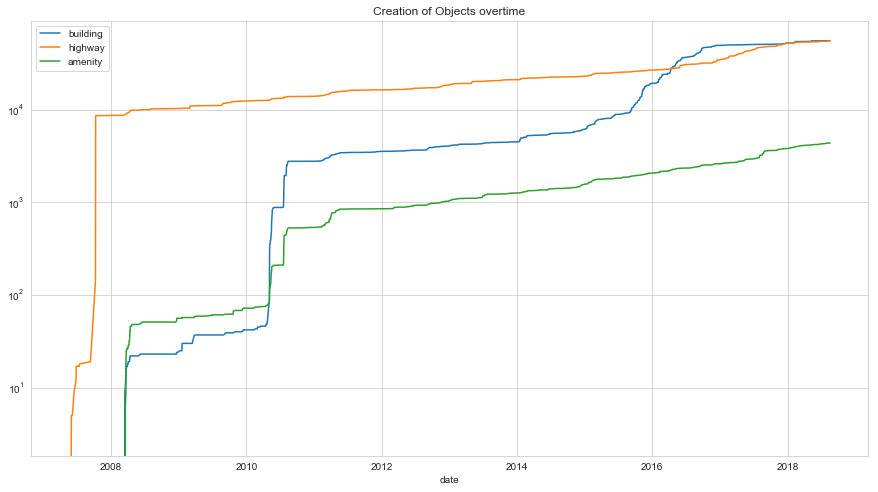

In [181]:
ax = df[(df.version==1) & (df.minorVersion==0)].groupby('date').aggregate({'building':'count','highway':'count','amenity':'count'}).cumsum().plot(figsize=(15,8))
ax.set_title('Creation of Objects overtime');
ax.set_yscale('LOG')

# Learning about Names

In [183]:
def extract_key(attributeString,attr):
    if type(attributeString)==str:
        try:
            tags   = attributeString.split("|-|")
            tuples = [x.split("-->") for x in tags]
            keys   = [x[0] for x in tuples]
            values = [x[1] for x in tuples]
            if attr in keys:
                return values[keys.index(attr)]
            else:
                return np.NaN
        except:
            print(attributeString)
            print("keys", keys)
            raise
    return np.NaN

In [184]:
df['nameAdded'] = df.aA.apply(lambda x: extract_key(x,'name'))

## When were names added to roads?

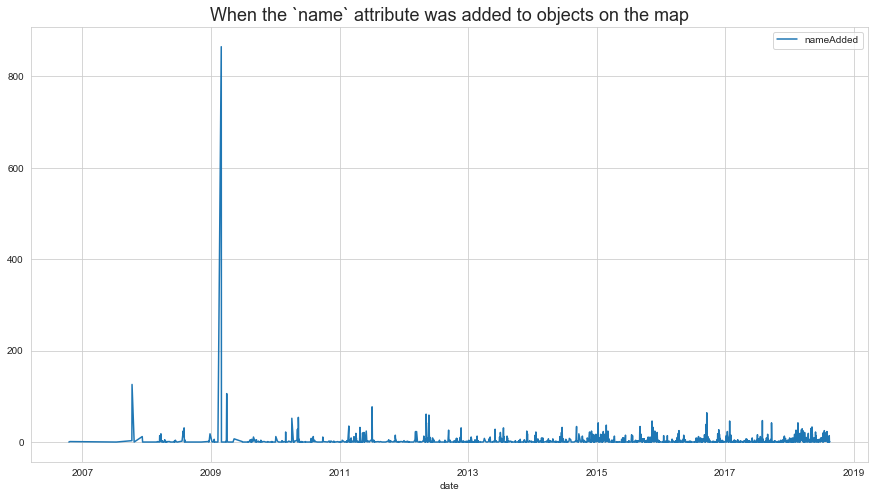

In [185]:
ax = df[pd.isnull(df.highway)].groupby('date').aggregate({'nameAdded':'count'}).plot(figsize=(15,8))
ax.set_title('When the `name` attribute was added to objects on the map',fontsize=18);

# Top 15 Mappers of 2018?

In [189]:
df[df.date > datetime.date(2018,1,1)].groupby('user').aggregate({'id':'count'}).sort_values(by='id',ascending=False).head(15)


,id
user,
Matthew Darwin,7257
lmum,3479
IanH,3390
Tyson Gersh,2952
mapper377,2789
alisonc42,1403
NixillUmbreon,1288
Юкатан,1027
Delocuro,922


## A heatmap of building edits?

In [208]:
import json; os
featColl = {'type':'FeatureCollection','features':[]}
for date, edits in df[pd.notnull(df.building)].groupby('date'):
    try:
        geometryColl = edits.center.apply(lambda x: {'type':'Point','coordinates':[float(y) for y in x.split(",")]})
        geojson = {
            'geometry':{'type':'GeometryCollection','geometries':list(geometryColl)},
            'type':"Feature",
            'properties': {'days_since_2005': (date - datetime.date(2005,1,1) ).days, 'edits':len(edits)}
        }
        featColl['features'].append(geojson)
    except:
        print("err--moving on")
    
json.dump(featColl, open("../docs/data/"+PLACE+".geojson",'w'))

print("Starting a local webserver in the `docs` directory: ")
os.system("cd ../docs && python -m SimpleHTTPServer 8000 & ")
print("\n\nCheck it out at: http://localhost:8000/index.html?data="+PLACE+".geojson")

Starting a local webserver in the `docs` directory: 


Check it out at: http://localhost:8000/index.html?data=detroit_michigan.geojson
